In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====================================================
# 0. Definir periodos de crecimiento por nodo
# ====================================================
periodos = {
    4: [
        ("01/05/2018", "30/11/2018"), # salvo un poco de la FASE 2, solo es fiable CMNDT
        ("01/04/2019", "30/11/2019"), # FASE 1 solo es fiable CMNDT
        ("09/04/2021", "15/11/2021"),
        ("07/05/2022", "14/11/2022"),
        ("01/04/2023", "30/11/2023"), # FASE 1 solo es fiable CMNDT
    ],
    6: [
        ("23/06/2018", "19/08/2018"), # tramo suelto aislado
        ("04/07/2019", "09/09/2019"), # tramo suelto aislado
        ("01/06/2020", "31/10/2020"), # salvo un poco de la FASE 2, solo es fiable CMNDT
        ("09/06/2021", "23/07/2021"), # tramo suelto aislado
        ("01/04/2023", "30/11/2023"), # salvo un poco de la FASE 2, solo es fiable CMNDT
    ]}
# Convertir cadenas a Timestamps
for nodo, tramos in periodos.items():
    periodos[nodo] = [
        (pd.to_datetime(start, dayfirst=True),
        pd.to_datetime(end,   dayfirst=True))for start, end in tramos]

# ====================================================
# 1. Cargar y preparar DataFrame base
# ====================================================
df = pd.read_csv(r"C:\Users\usuario\Desktop\TFG\DATASET\datasets_modificados\year_all\year_all.csv",low_memory=False)
df['instante'] = pd.to_datetime(df['instante'])
# Filtrar por los nodos que tenemos periodos
df = df[df['id_nodo'].isin(periodos.keys())].copy()

# Índice temporal
df.set_index('instante', inplace=True)
df.sort_index(inplace=True)

# ====================================================
# 2. Limpieza al nivel original (sin recorte de fechas)
# ====================================================
df_cleaned = df.copy()

# 2.1 Humedades fuera de [0,1]
hum_vars = ['var1','var2','var3','var4','var5','var6','var9']
for col in hum_vars:
    minimo = 0.15 if col == 'var9' else 0.25
    mask = (df_cleaned[col] < minimo) | (df_cleaned[col] > 1)
    df_cleaned.loc[mask, col] = np.nan
    # interpolamos y luego aplicamos clip(upper=1)
    df_cleaned[col] = (df_cleaned[col].interpolate(method='time').clip(upper=1.0))

# 2.2 Temperaturas fuera de rango [5°C, 50°C]
temp_vars = ['var7','var8']
for col in temp_vars:
    mask = (df_cleaned[col] < 5) | (df_cleaned[col] > 50)
    df_cleaned.loc[mask, col] = np.nan
    df_cleaned[col] = df_cleaned[col].interpolate(method='time')
    
# 2.3 Rellenar NaNs extremos
df_cleaned.fillna(method='bfill', inplace=True)
df_cleaned.fillna(method='ffill', inplace=True)

# 2.4 Eliminar columnas no deseadas
df_cleaned.drop(columns=['var11', 'goteros_linea'], inplace=True)

# 2.5 Renombrar variables con prefijos legibles
rename_map = {
    'var1': 'HS10', 'var2': 'HS20', 'var3': 'HS30',
    'var4': 'HS40', 'var5': 'HS50', 'var6': 'HS60',
    'var7': 'TS30', 'var8': 'TA', 'var9': 'HA'}

df_cleaned.rename(columns=rename_map, inplace=True)
df.rename(columns=rename_map, inplace=True)

# ====================================================
# 3. Reconstruir datasets_por_tramo a partir de df_cleaned
# ====================================================
datasets_por_tramo = {}
for nodo, tramos in periodos.items():
    df_n = df_cleaned[df_cleaned['id_nodo'] == nodo]
    segmentos = []
    for inicio, fin in tramos:
        seg = df_n.loc[inicio:fin].copy()
        # — Corrección de resets en 'litros_arbol' para este tramo —
        offset = 0.0
        prev   = None
        corr   = []
        for current in seg['litros_arbol']:
            if prev is None:
                corr.append(current)
            else:
                if current < prev:
                    offset += prev
                corr.append(current + offset)
            prev = current
        seg['litros_arbol'] = corr
        
        # 1) Marcar como NaN todo dendrómetro > 60
        mask = seg['dendrometro'] > 60
        seg.loc[mask, 'dendrometro'] = np.nan
        seg['dendrometro'] = seg['dendrometro'].interpolate(method='pad')
        segmentos.append(seg)
    datasets_por_tramo[nodo] = segmentos

# ====================================================
# 4. Crear DataFrame global con metadata de cada tramo
# ====================================================
global_list = []
for nodo, tramos in periodos.items():
    for idx, (inicio, fin) in enumerate(tramos):
        df_seg = datasets_por_tramo[nodo][idx].reset_index()
        df_seg.rename(columns={'instante':'fecha'}, inplace=True)
        df_seg['nodo'] = nodo
        df_seg['t0']   = inicio
        df_seg['t1']   = fin
        global_list.append(df_seg)

df_global = pd.concat(global_list, ignore_index=True)

# ====================================================
# 5. Resumen
# ====================================================
print("Segmentos extraídos por nodo:")
for nodo, segs in datasets_por_tramo.items():
    print(f"  Nodo {nodo}: {len(segs)} tramos")

Segmentos extraídos por nodo:
  Nodo 4: 5 tramos
  Nodo 6: 5 tramos


Tramos disponibles por nodo:
 Nodo 4:
   [0] 2018-05-01 ➞ 2018-11-30
   [1] 2019-04-01 ➞ 2019-11-30
   [2] 2021-04-09 ➞ 2021-11-15
   [3] 2022-05-07 ➞ 2022-11-14
   [4] 2023-04-01 ➞ 2023-11-30
 Nodo 6:
   [0] 2018-06-23 ➞ 2018-08-19
   [1] 2019-07-04 ➞ 2019-09-09
   [2] 2020-06-01 ➞ 2020-10-31
   [3] 2021-06-09 ➞ 2021-07-23
   [4] 2023-04-01 ➞ 2023-11-30


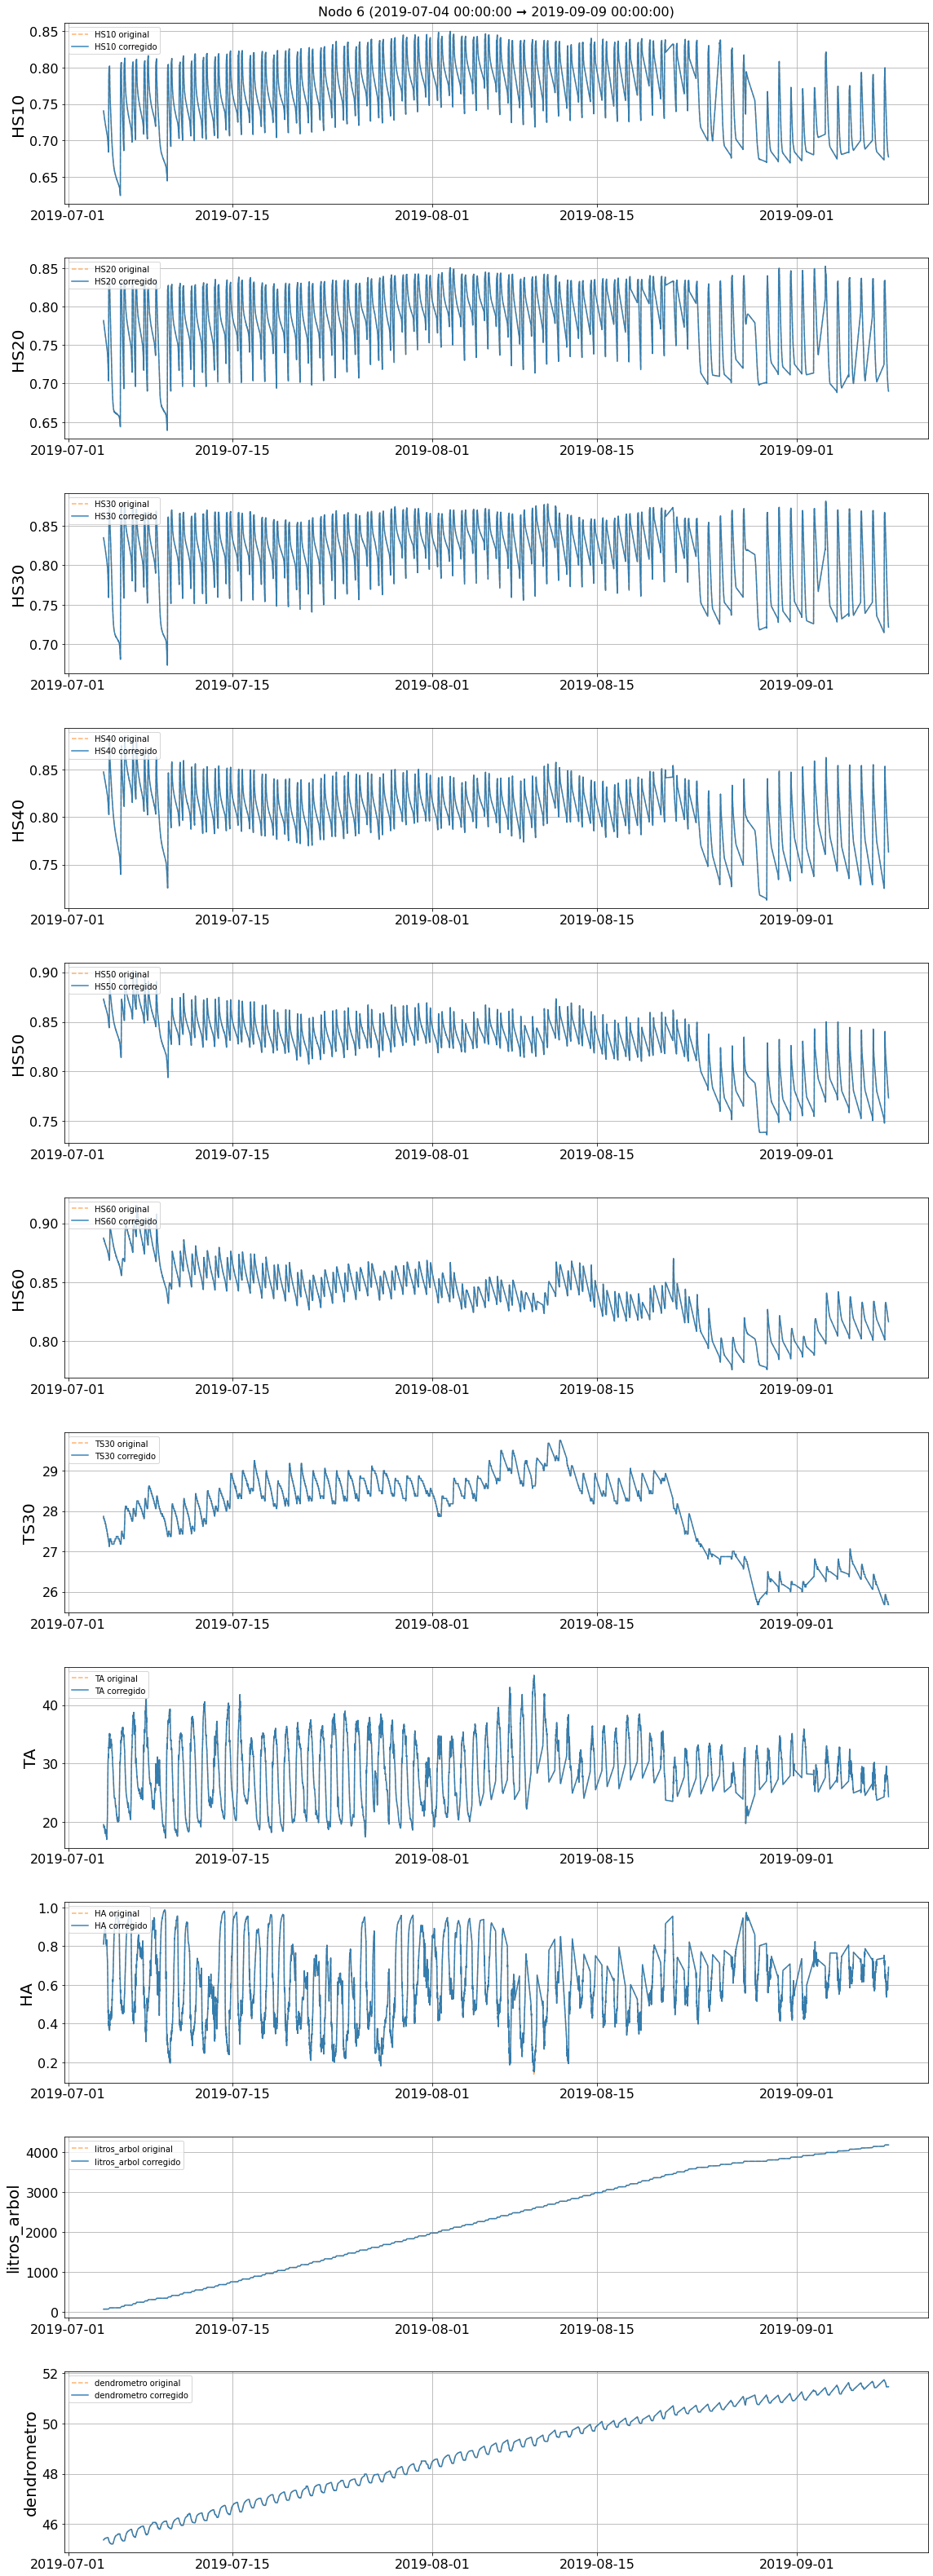

In [2]:
# 1) Mira qué tramos hay para cada nodo
print("Tramos disponibles por nodo:")
for nodo, tramos in periodos.items():
    print(f" Nodo {nodo}:")
    for idx, (start, end) in enumerate(tramos):
        print(f"   [{idx}] {start.date()} ➞ {end.date()}")

# 2) Elige aquí el nodo y el índice de tramo que quieres graficar
mi_nodo   = 6
tramo_idx  = 1

# 3) Obtén las fechas directamente del dict
mi_inicio, mi_fin = periodos[mi_nodo][tramo_idx]

# ——————————————————————————————————————————————
# Filtrado por nodo y periodo
# ——————————————————————————————————————————————
df_seg_proc = df[(df['id_nodo'] == mi_nodo) & 
                 (df.index >= mi_inicio) & 
                 (df.index <= mi_fin)]

df_seg_cl = datasets_por_tramo[mi_nodo][tramo_idx]


# ——————————————————————————————————————————————
# Graficar original vs corregido para cada variable numérica
# ——————————————————————————————————————————————
numeric_cols = [c for c in df_cleaned.select_dtypes(include=[np.number]).columns if c != 'id_nodo']
n_vars = len(numeric_cols)
plt.figure(figsize=(16, 4 * n_vars))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_vars, 1, i)
    
    # Serie original
    plt.plot(df_seg_proc.index, df_seg_proc[col],
             linestyle='--', alpha=0.6, color='tab:orange',
             label=f"{col} original")
    
    # Serie corregida
    plt.plot(df_seg_cl.index, df_seg_cl[col],
             linestyle='-', alpha=0.9, color='tab:blue',
             label=f"{col} corregido")
    
    if i == 1:
        plt.title(f"Nodo {mi_nodo} ({mi_inicio} ➞ {mi_fin})",fontsize=16, pad=10)
        
    plt.ylabel(col, fontsize=20)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.legend(loc='upper left')
    plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [3]:
# ====================================================
# Aplicar agregación diaria y métricas a todos los tramos
# ====================================================

# dict donde guardaremos, para cada nodo, la lista de DataFrames diarios procesados
daily_por_tramo = {}

for nodo, segmentos in datasets_por_tramo.items():
    daily_list = []
    for seg in segmentos:
        # guardamos el valor de id_nodo
        nodo_val = seg['id_nodo'].iat[0]
        # 1) eliminamos id_nodo antes de agregar
        df_daily = (seg.drop(columns='id_nodo').resample('D').agg(['min','mean','max']))
        df_daily.columns = [f"{col}_{stat}" for col,stat in df_daily.columns]
        df_daily['id_nodo'] = nodo_val
        
        # 2) Métricas dendrómetro
        df_daily['MNDT']  = df_daily['dendrometro_min']
        df_daily['MXDT']  = df_daily['dendrometro_max']
        df_daily['MCD']   = df_daily['MXDT'] - df_daily['MNDT']
        df_daily['CMNDT'] = df_daily['MNDT'].diff()
        df_daily['CMXDT'] = df_daily['MXDT'].diff()
        
        # 3) Litros regados diarios
        df_daily['litros_diarios'] = (df_daily['litros_arbol_max'] - df_daily['litros_arbol_min'])
        prefijos = ['dendrometro', 'litros_arbol']
        cols_a_borrar = [c for c in df_daily.columns if any(c.startswith(f"{p}_") for p in prefijos)]
        df_daily.drop(columns=cols_a_borrar, inplace=True)
        daily_list.append(df_daily)
    daily_por_tramo[nodo] = daily_list

In [4]:
print(df_daily.columns)

Index(['HS10_min', 'HS10_mean', 'HS10_max', 'HS20_min', 'HS20_mean',
       'HS20_max', 'HS30_min', 'HS30_mean', 'HS30_max', 'HS40_min',
       'HS40_mean', 'HS40_max', 'HS50_min', 'HS50_mean', 'HS50_max',
       'HS60_min', 'HS60_mean', 'HS60_max', 'TS30_min', 'TS30_mean',
       'TS30_max', 'TA_min', 'TA_mean', 'TA_max', 'HA_min', 'HA_mean',
       'HA_max', 'id_nodo', 'MNDT', 'MXDT', 'MCD', 'CMNDT', 'CMXDT',
       'litros_diarios'],
      dtype='object')


In [5]:
df_ivia = pd.read_csv('C:/Users/usuario/Desktop/TFG/DATASET/meteo_ivia.csv',index_col='fecha')
df_ivia.index = pd.to_datetime(df_ivia.index, dayfirst=True)
df_ivia

,temp,temp_max,temp_min,humedad,humedad_max,humedad_min,radiacion,precipitacion,eto
fecha,,,,,,,,,
2018-01-01,14.96,19.93,10.49,35.55,49.61,21.10,10.89,0.0,2.96
2018-01-02,16.25,20.66,10.94,43.86,53.56,32.42,10.98,0.0,3.04
2018-01-03,17.62,22.47,13.49,53.34,64.48,40.84,9.98,0.0,2.94
2018-01-04,18.24,24.46,14.96,52.55,64.14,36.61,10.78,0.0,2.98
2018-01-05,14.46,21.33,7.08,55.88,79.10,33.75,10.91,0.0,1.78
...,...,...,...,...,...,...,...,...,...
2023-12-27,7.32,16.79,-0.24,73.40,96.50,34.46,10.10,0.0,0.81
2023-12-28,8.15,16.32,1.18,62.74,95.50,32.48,7.82,0.0,0.96
2023-12-29,10.19,16.12,5.25,53.68,76.90,28.59,5.17,0.0,0.94


In [6]:
df_ivia.describe()

,temp,temp_max,temp_min,humedad,humedad_max,humedad_min,radiacion,precipitacion,eto
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,17.954747,24.599283,12.181461,64.774263,87.945212,38.333651,17.362323,1.044048,3.366787
std,6.191502,6.633383,6.161440,13.145396,10.482684,13.527681,7.440939,6.197886,1.735878
min,3.120000,5.220000,-3.360000,24.010000,36.120000,7.170000,1.380000,0.000000,0.000000
25%,12.825000,19.305000,7.360000,55.185000,83.900000,28.265000,10.980000,0.000000,1.820000
50%,17.740000,24.370000,12.070000,65.860000,91.200000,37.130000,17.090000,0.000000,3.140000
75%,23.495000,30.055000,17.580000,74.700000,95.100000,47.275000,24.185000,0.000000,4.915000
max,32.310000,42.880000,25.280000,96.700000,100.000000,95.000000,31.280000,154.800000,8.330000


In [7]:
# Iterar sobre el diccionario de listas de DataFrames
for arbol_id, lista_dfs in daily_por_tramo.items():
    for i in range(len(lista_dfs)):
        df_original = lista_dfs[i]

        # Intersección de fechas con df_sel (variables IVIA)
        fechas_comunes = df_original.index.intersection(df_ivia.index)
        df_vars_ivias = df_ivia.loc[fechas_comunes]

        # Concatenar por columnas, alineando por fecha
        df_combinado = pd.concat([df_original.loc[fechas_comunes], df_vars_ivias], axis=1)
        
        df_combinado = df_combinado.rename(columns={'temp': 'temp_mean','humedad': 'humedad_mean'})
        for col in df_combinado.columns:
            if col.startswith('humedad'):
                df_combinado[col] = df_combinado[col] / 100

        # Guardar el DataFrame combinado en su lugar
        lista_dfs[i] = df_combinado

In [8]:
daily_por_tramo[6][0].columns

Index(['HS10_min', 'HS10_mean', 'HS10_max', 'HS20_min', 'HS20_mean',
       'HS20_max', 'HS30_min', 'HS30_mean', 'HS30_max', 'HS40_min',
       'HS40_mean', 'HS40_max', 'HS50_min', 'HS50_mean', 'HS50_max',
       'HS60_min', 'HS60_mean', 'HS60_max', 'TS30_min', 'TS30_mean',
       'TS30_max', 'TA_min', 'TA_mean', 'TA_max', 'HA_min', 'HA_mean',
       'HA_max', 'id_nodo', 'MNDT', 'MXDT', 'MCD', 'CMNDT', 'CMXDT',
       'litros_diarios', 'temp_mean', 'temp_max', 'temp_min', 'humedad_mean',
       'humedad_max', 'humedad_min', 'radiacion', 'precipitacion', 'eto'],
      dtype='object')

In [9]:
import pickle

with open('C:/Users/usuario/Desktop/TFG/DATASET/daily_por_tramo.pkl', 'wb') as f:
    pickle.dump(daily_por_tramo, f)

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

with open('C:/Users/usuario/Desktop/TFG/DATASET/daily_por_tramo.pkl', 'rb') as f:
    daily_por_tramo = pickle.load(f)
    
periodos = {
    4: [
        ("01/05/2018", "30/11/2018"), # salvo un poco de la FASE 2, solo es fiable CMNDT
        ("01/04/2019", "30/11/2019"), # FASE 1 solo es fiable CMNDT
        ("09/04/2021", "15/11/2021"),
        ("07/05/2022", "14/11/2022"),
        ("01/04/2023", "30/11/2023"), # FASE 1 solo es fiable CMNDT
    ],
    6: [
        ("23/06/2018", "19/08/2018"), # tramo suelto aislado
        ("04/07/2019", "22/10/2019"), # tramo suelto aislado
        ("31/05/2020", "31/10/2020"), # salvo un poco de la FASE 2, solo es fiable CMNDT
        ("30/04/2021", "23/07/2021"), # tramo suelto aislado
        ("01/04/2023", "30/11/2023"), # salvo un poco de la FASE 2, solo es fiable CMNDT
    ]}

# Convertir cadenas a Timestamps
for nodo, tramos in periodos.items():
    periodos[nodo] = [
        (pd.to_datetime(start, dayfirst=True),
        pd.to_datetime(end,   dayfirst=True)) for start, end in tramos]

In [3]:
daily_por_tramo[4][1]

,HS10_min,HS10_mean,HS10_max,HS20_min,HS20_mean,HS20_max,HS30_min,HS30_mean,HS30_max,HS40_min,...,litros_diarios,temp_mean,temp_max,temp_min,humedad_mean,humedad_max,humedad_min,radiacion,precipitacion,eto
2019-04-01,0.8206,0.828478,0.8383,0.8008,0.810198,0.8298,0.7646,0.774287,0.7946,0.7201,...,11.6,14.59,19.73,11.81,0.8630,0.976,0.6187,14.34,0.00,2.35
2019-04-02,0.8155,0.820372,0.8246,0.7981,0.800754,0.8070,0.7620,0.767327,0.7740,0.7163,...,0.0,16.64,23.52,10.89,0.7420,0.963,0.3769,20.13,0.00,3.34
2019-04-03,0.8033,0.823414,0.8469,0.7917,0.808150,0.8380,0.7611,0.776705,0.8124,0.7166,...,11.2,17.37,24.66,9.82,0.6189,0.951,0.2718,22.72,0.20,4.08
2019-04-04,0.7978,0.811141,0.8228,0.7919,0.797487,0.8075,0.7604,0.767054,0.7763,0.7161,...,0.0,14.21,19.66,10.22,0.6475,0.917,0.2404,22.16,0.00,3.54
2019-04-05,0.7889,0.815065,0.8452,0.7860,0.804969,0.8372,0.7569,0.775348,0.8122,0.7124,...,19.4,12.76,20.19,7.82,0.7240,0.896,0.3763,14.67,3.17,2.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25,0.7527,0.776782,0.7983,0.7550,0.776857,0.8025,0.7227,0.747614,0.7838,0.6868,...,32.4,15.44,21.62,9.23,0.6488,0.827,0.4789,7.72,0.00,1.61
2019-11-26,0.7618,0.767863,0.7760,0.7632,0.766521,0.7738,0.7311,0.735309,0.7435,0.6964,...,0.0,15.21,22.48,9.56,0.7160,0.895,0.4588,10.70,0.00,1.52
2019-11-27,0.7580,0.778523,0.8069,0.7604,0.779001,0.8043,0.7295,0.750137,0.7836,0.6950,...,29.4,16.39,22.41,10.17,0.6105,0.916,0.3443,11.90,0.00,2.05
2019-11-28,0.7562,0.762806,0.7722,0.7602,0.764628,0.7736,0.7288,0.734348,0.7442,0.6927,...,0.0,15.11,20.95,9.76,0.6096,0.841,0.3972,11.02,0.00,1.58


Tramos disponibles por nodo:
 Nodo 4:
   [0] 2018-05-01 ➞ 2018-11-30
   [1] 2019-04-01 ➞ 2019-11-30
   [2] 2021-04-09 ➞ 2021-11-15
   [3] 2022-05-07 ➞ 2022-11-14
   [4] 2023-04-01 ➞ 2023-11-30
 Nodo 6:
   [0] 2018-06-23 ➞ 2018-08-19
   [1] 2019-07-04 ➞ 2019-10-22
   [2] 2020-05-31 ➞ 2020-10-31
   [3] 2021-04-30 ➞ 2021-07-23
   [4] 2023-04-01 ➞ 2023-11-30


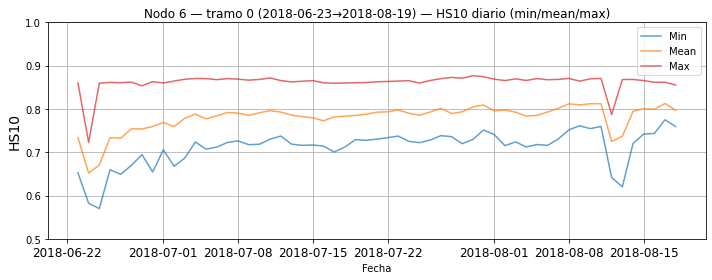

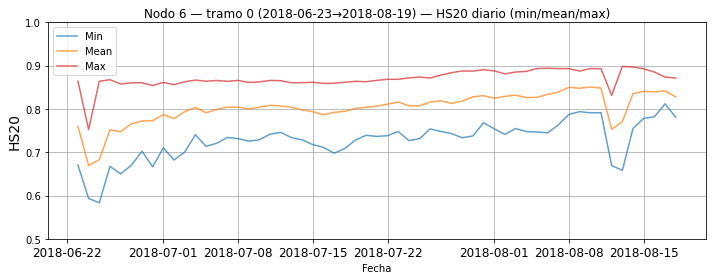

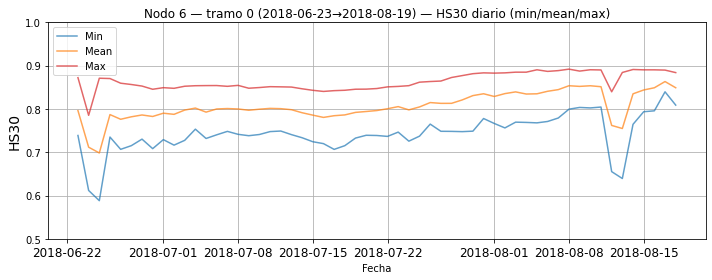

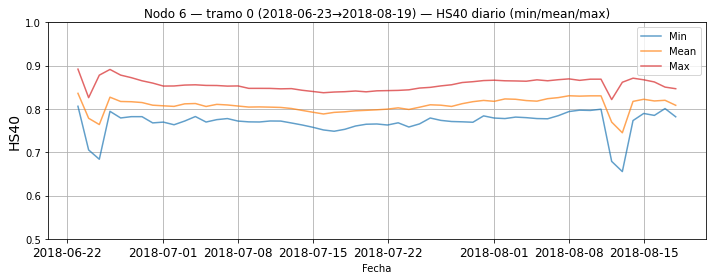

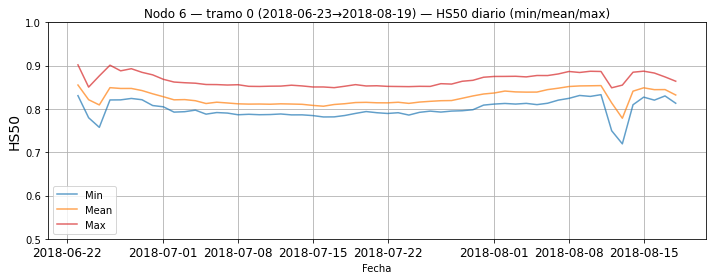

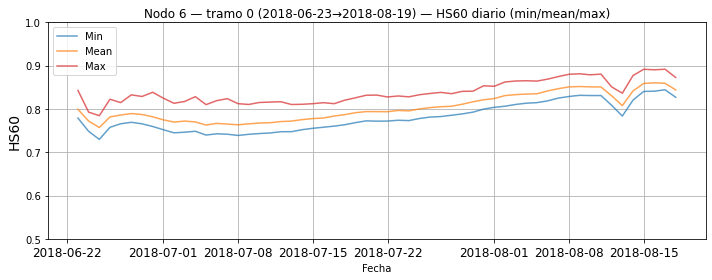

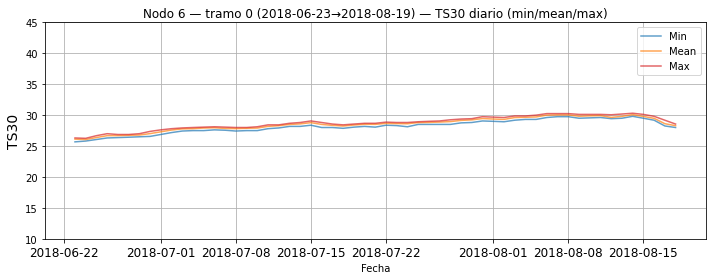

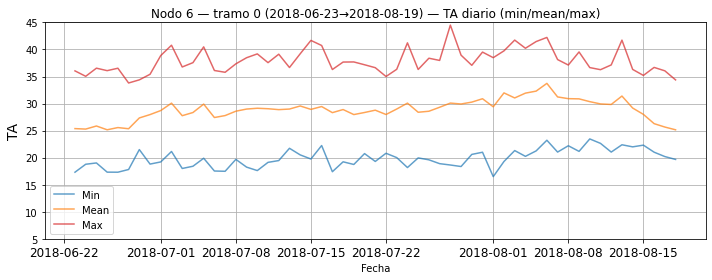

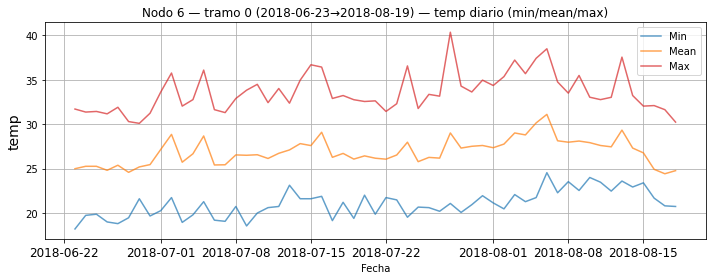

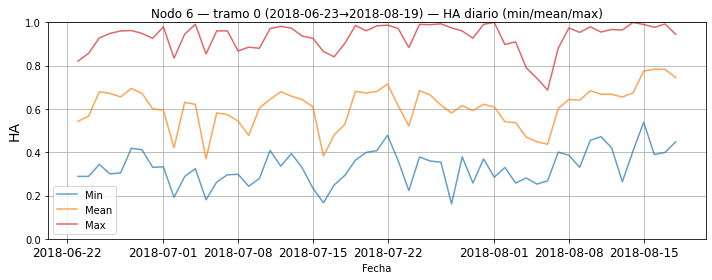

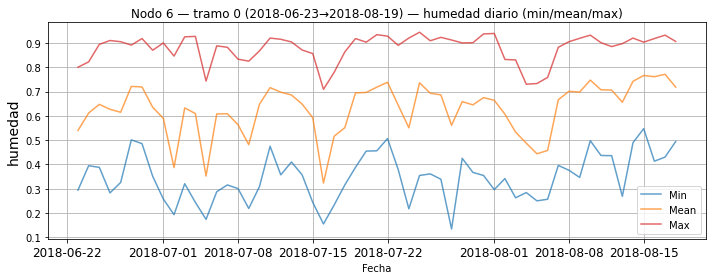

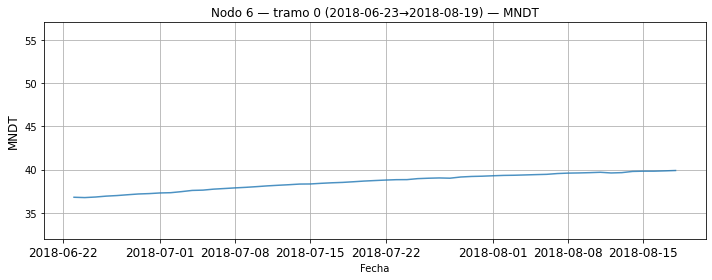

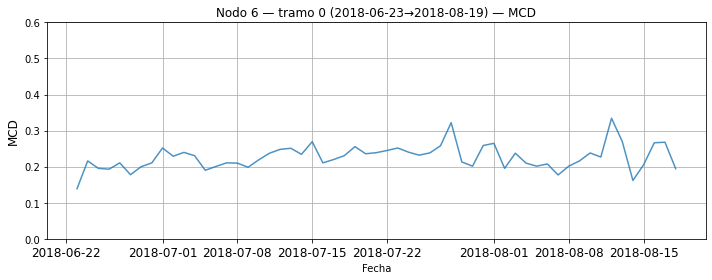

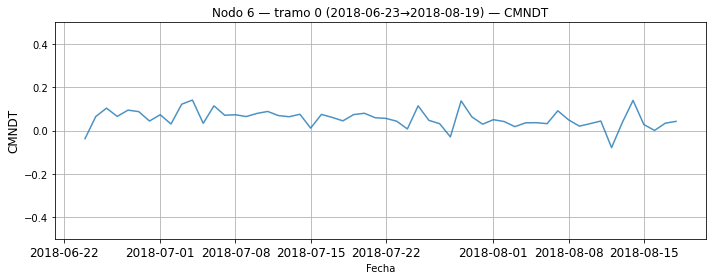

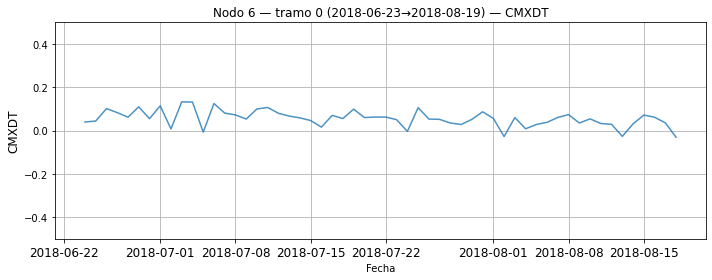

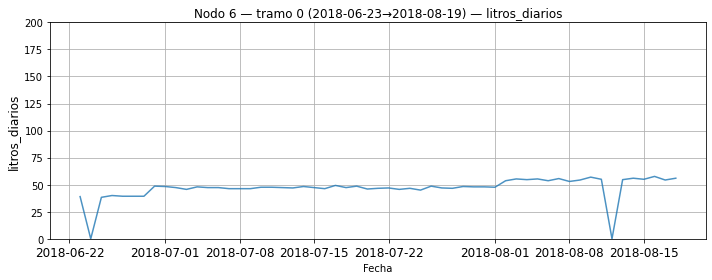

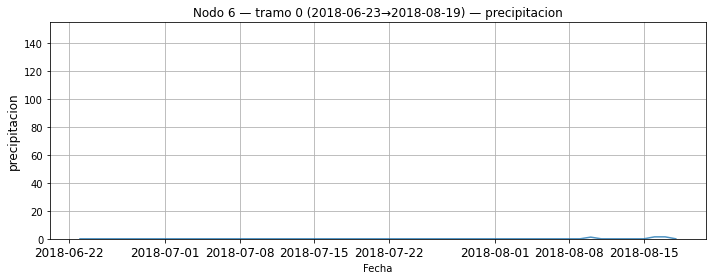

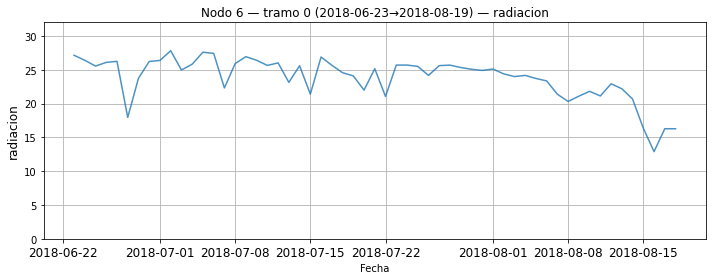

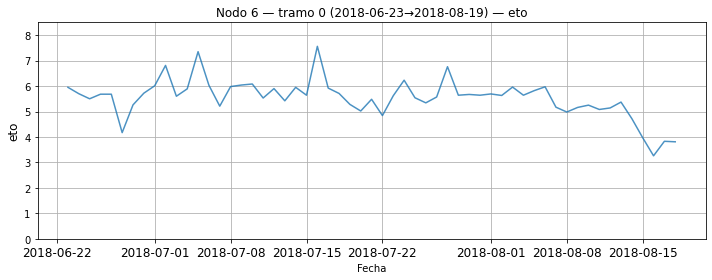

In [4]:
# 1) Mostrar tramos disponibles
print("Tramos disponibles por nodo:")
for nodo, tramos in periodos.items():
    print(f" Nodo {nodo}:")
    for idx, (start, end) in enumerate(tramos):
        print(f"   [{idx}] {start.date()} ➞ {end.date()}")

# 2) Selecciona aquí el nodo y el índice de tramo que quieres graficar
nodo_sel   = 6
tramo_idx  = 0

# 3) Recupera el DataFrame diario de ese tramo
df_daily_seg = daily_por_tramo[nodo_sel][tramo_idx]
inicio, fin  = periodos[nodo_sel][tramo_idx]
title_base   = f"Nodo {nodo_sel} — tramo {tramo_idx} ({inicio.date()}→{fin.date()})"

ylims_vars = {
    'HS':   (0.5, 1),    # humedad de suelo
    'HA':   (0, 1),    # humedad aire
    'TS30': (10, 45),  # temp. suelo
    'TA':   (5, 45),  # temp. aire
}

# 4) Graficar HS10–HS60, TS30, TA y HA con todos los estadísticos
vars_diarias = ['HS10','HS20','HS30','HS40','HS50','HS60','TS30','TA','temp','HA','humedad']
suffixes     = ['min','mean','max']
colors       = {'min':'tab:blue','mean':'tab:orange','median':'tab:green','max':'tab:red'}

for var in vars_diarias:
    # Usar solo ciertos sufijos si la variable es 'temp' o 'humedad'
    if var in ['temp', 'humedad']:
        sufijos_validos = ['min', 'mean', 'max']
    else:
        sufijos_validos = suffixes

    cols = [f"{var}_{s}" for s in sufijos_validos if f"{var}_{s}" in df_daily_seg.columns]
    
    plt.figure(figsize=(10,4))
    for s in sufijos_validos:
        plt.plot(
            df_daily_seg.index,
            df_daily_seg[f"{var}_{s}"],
            label=f"{s.capitalize()}",
            color=colors[s],
            alpha=0.7)
        
    for key, lim in ylims_vars.items():
        if var.startswith(key):
            plt.ylim(*lim)
            break
            
    plt.ylabel(var, fontsize=14)
    plt.tick_params(axis='x', labelsize=12)
    plt.title(f"{title_base} — {var} diario ({'/'.join(sufijos_validos)})")
    plt.xlabel("Fecha")
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5) Graficar métricas de dendrómetro, riego y climatología
ylims_cols = {'MNDT':(32, 57),'MXDT':(32, 57),'CMNDT':(-0.5, 0.5),'CMXDT':(-0.5, 0.5),'MCD':(0, 0.6),'litros_diarios':(0, 200),
    'precipitacion':(0, 155),'radiacion':(0,32), 'eto': (0,8.5)}

# 5) Graficar métricas de dendrómetro y riego diario
for col in ['MNDT','MCD','CMNDT','CMXDT','litros_diarios','precipitacion','radiacion','eto']:
    plt.figure(figsize=(10,4))
    plt.plot(df_daily_seg.index, df_daily_seg[col], alpha=0.8)
    for key, lim in ylims_cols.items():
        if col.startswith(key):
            plt.ylim(*lim)
            break
            
    plt.ylabel(col, fontsize=12)
    plt.tick_params(axis='x', labelsize=12)
    
    plt.title(f"{title_base} — {col}")
    plt.xlabel("Fecha")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
df_daily_seg

,HS10_min,HS10_mean,HS10_max,HS20_min,HS20_mean,HS20_max,HS30_min,HS30_mean,HS30_max,HS40_min,...,litros_diarios,temp_mean,temp_max,temp_min,humedad_mean,humedad_max,humedad_min,radiacion,precipitacion,eto
2019-07-04,0.6533,0.712385,0.8023,0.6621,0.736865,0.8348,0.7113,0.791508,0.8747,0.7845,...,33.000000,25.84,31.57,19.01,0.6294,0.897,0.3693,27.10,0.0,5.87
2019-07-05,0.6240,0.713841,0.8131,0.6438,0.737292,0.8318,0.6807,0.782671,0.8799,0.7397,...,67.333333,26.69,32.90,20.28,0.7020,0.918,0.4461,27.07,0.0,5.74
2019-07-06,0.6976,0.750329,0.8115,0.6962,0.775578,0.8315,0.7667,0.830497,0.8768,0.8152,...,73.333333,28.05,35.23,21.96,0.6822,0.900,0.3892,20.48,0.0,5.05
2019-07-07,0.7019,0.754589,0.8164,0.6902,0.774348,0.8286,0.7520,0.823131,0.8674,0.8022,...,66.000000,29.83,39.83,24.68,0.5677,0.792,0.1966,18.68,0.0,5.74
2019-07-08,0.6784,0.732966,0.8122,0.6683,0.747048,0.8349,0.7154,0.796310,0.8689,0.7688,...,33.333333,25.40,29.45,20.88,0.7510,0.922,0.4771,15.31,0.0,3.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-04,0.6742,0.715808,0.7745,0.6882,0.756225,0.8332,0.7280,0.800044,0.8703,0.7429,...,38.666667,24.94,30.17,20.62,0.7550,0.940,0.4904,18.91,0.0,3.84
2019-09-05,0.6829,0.721707,0.7753,0.7000,0.765040,0.8376,0.7352,0.802935,0.8715,0.7353,...,38.666667,24.71,29.12,21.35,0.7550,0.923,0.5052,18.52,0.0,3.83
2019-09-06,0.6879,0.735185,0.7934,0.7035,0.769973,0.8367,0.7391,0.806962,0.8686,0.7285,...,24.666667,24.20,29.17,21.55,0.7430,0.879,0.5077,18.23,0.0,3.87
2019-09-07,0.6843,0.730873,0.7906,0.7021,0.767936,0.8362,0.7358,0.804616,0.8693,0.7287,...,31.666667,23.44,28.65,20.35,0.7330,0.918,0.5179,18.13,0.2,3.76


In [15]:
import pickle

with open('daily_por_tramo.pkl', 'wb') as f:
    pickle.dump(daily_por_tramo, f)